In [1]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as optimize
from iminuit import Minuit

In [2]:
def chisq(obs, exp, error):
    return np.sum(np.square(obs - exp) / np.square(error))

We will first try with the usual broken power law:

In [3]:
def br_po_lw(xdata, E1, fl_0, lam1, sqrtdelta_lam12):
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return polw

Now let's add the $\chi^2$ to the function in order to minimize:

In [4]:
def br_po_lw_chsq(params): 
    #you need to define theE, SED and SED_u before(E and SED must be a numpy.array and SED an scalar or a numpy.array)
    E1, fl_0, lam1, sqrtdelta_lam12 = params
    E0 = xdata[0]
    polw = np.zeros(len(xdata))
    lam2 = lam1 + sqrtdelta_lam12**2 #for multiple broken power law add lam_i = lam_(i-1) + delta_lam
    phi_0 = fl_0
    phi_1 = phi_0 * ((E1/E0) ** (-lam1))
    for i in range(len(xdata)):
        if xdata[i] < E1:#you can add E>E0
            polw[i] = phi_0 * ((xdata[i]/E0) ** (-lam1))
        else:#you can add elifs for multiple broken power law
            polw[i] = phi_1 * ((xdata[i]/E1) ** (-lam2))
    return np.sum(np.square(ydata - polw) / np.square(ydata_u))

In this case we will define the multiple broken power law, but as it depends on the number of knots it will be much longer.

from now on the position of the knots will not be a free parameter anymore in order to make the convergence of the fit easier

In [5]:
def multiple_bpl(xdata, params):
    if knots < 3 or knots > 30: #change this when adding more number of knots
        raise Exception('at thins moment knots can only be equal to 3')
    else:
        polw = np.zeros(len(xdata))
        Es = np.geomspace(xdata[0], xdata[-1], knots)
        lam = np.zeros(knots-1)
        phi = np.zeros(knots-1)
        phi_0 = params[0] #len(sqrtdelta_lam) = len(lam)-1 = len(phi)-1
        lam0 = params[1]
        sqrtdelta_lam = params[2:knots]
        lam[0] = lam0
        phi[0] = phi_0
        for i in range(1, knots-1):
            lam[i] = lam[i-1] + (sqrtdelta_lam[i-1]) ** 2
            phi[i] = phi[i-1] * ((Es[i]/Es[i-1]) ** (-lam[i-1]))
        for i in range(knots-1):
            for j in range(len(xdata)):
                if Es[i] < xdata[j] <= Es[i+1]:
                    polw[j] = phi[i] * ((xdata[j] / Es[i]) ** (-lam[i]))
                elif xdata[j] <= Es[1]:
                    polw[j] = phi[0] * ((xdata[j] / Es[0]) ** (-lam[0]))
                elif xdata[j] > Es[-1]:
                    polw[j] = phi[-2] * ((xdata[j] / Es[-2]) ** (-lam[-2]))
    return polw


In [6]:
# least-squares score function = sum of data residuals squared
def LSQ(params):
    return np.sum((ydata - multiple_bpl(xdata, params)) ** 2 / ydata_u ** 2)

Now we define the function of the fit

In [7]:
def multiple_bpl_fit(initial_guess):
    print('Warning: the shape of the parametes will depend on the number of knots (defined as knots)')
    print('Warning: this will give the parameters of the fit and its errors which have to be put into the multiple_bpl function in order to get the fit')
    LSQ.errordef = Minuit.LIKELIHOOD

    m = Minuit(LSQ, initial_guess)

    m.migrad()
    print(m.values)

    m.hesse()
    print(m.errors)

    return m

In [8]:
file = np.loadtxt('tau_dominguez11.out')

pdfile = pd.DataFrame(file)
pdfile = pdfile.rename(columns={ 0 : 'E [TeV]', 1: 'tau z=0.01', 2: 'tau z=0.02526316', 3: 'tau z=0.04052632', 4: 'tau z=0.05578947', 5: 'tau z=0.07105263', 6: 'tau z=0.08631579', 7: 'tau z=0.10157895', 8: 'tau z=0.11684211', 9: 'tau z=0.13210526', 10: 'tau z=0.14736842', 11: 'tau z=0.16263158', 12: 'tau z=0.17789474', 13: 'tau z=0.19315789', 14: 'tau z=0.20842105'})

E = pdfile['E [TeV]'].to_numpy()
tau = pdfile['tau z=0.20842105'].to_numpy()
logE = np.log10(E)

K =  8.70e-6 #m−2  s−1  TeV−1
dNdE = K / ((E/0.25)**2.03) 
m_tau = -tau
dNdEa = dNdE * np.exp(m_tau)
SED = np.square(E) * dNdEa
SED_u = SED * 0.1

In [9]:
ydata = SED[3:37]
xdata = E[3:37]
knots = 5
ydata_u = SED_u[3:37]
initial_guess = np.array([5e-7, 0, 1, 1, 1]) #phi_0, lam1, deltas (len(deltas)=knots-2))
things = multiple_bpl_fit(initial_guess=initial_guess)

<ValueView x0=5.568931121153179e-07 x1=0.02025178832421636 x2=0.979662624522519 x3=0.7604673857839036 x4=0.00024572666941751115>
<ErrorView x0=2.3375530056138574e-08 x1=0.05200296277676078 x2=0.04162303175234304 x3=0.03570923216424672 x4=0.14361293137597533>


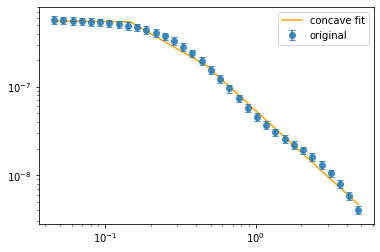

In [10]:
Egam = np.geomspace(E[3],E[36], 300)

plt.plot(Egam, multiple_bpl(Egam, things.values), label='concave fit', color = 'orange')
plt.errorbar(xdata, ydata, label='original',yerr = ydata_u, capsize=3, fmt='o', alpha=0.8)
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()